In [1]:
# 载入SimGCD模型
import torch
import sys
sys.path.append("/wang_hp/zhy/SimGCD-main")
from model import DINOHead
import torch.nn as nn

backbone = torch.hub.load('facebookresearch/dino:main', 'dino_vitb16')
projector = DINOHead(in_dim=768, out_dim=200, nlayers=3)
model = nn.Sequential(backbone, projector).to('cuda')
checkpoint = torch.load('/wang_hp/zhy/SimGCD-main/dev_outputs/simgcd/log/init_test_(04.09.2023_|_50.012)/checkpoints/model.pt')
model.load_state_dict(checkpoint['model'])

/opt/conda/envs/gcd/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


<All keys matched successfully>

In [2]:
# 载入验证集
from torchvision import transforms
from PIL import ImageOps, ImageFilter
import random
import pandas as pd
from torchvision.datasets.folder import default_loader
from torchvision.datasets.utils import download_url
from torch.utils.data import Dataset
from copy import deepcopy
import numpy as np
import os
from torch.utils.data import DataLoader

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
image_size = 224
interpolation = 3
crop_pct = 0.875
test_transform = transforms.Compose([
    transforms.Resize(int(image_size / crop_pct), interpolation),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=torch.tensor(mean),
        std=torch.tensor(std))
])

class CustomCub2011(Dataset):
    base_folder = 'CUB_200_2011/images'
    url = 'http://www.vision.caltech.edu/visipedia-data/CUB-200-2011/CUB_200_2011.tgz'
    filename = 'CUB_200_2011.tgz'
    tgz_md5 = '97eceeb196236b17998738112f37df78'

    def __init__(self, root='/wang_hp/zhy/gcd-task/data', train=True, transform=None, target_transform=None, loader=default_loader, download=True):

        self.root = os.path.expanduser(root)
        self.transform = transform
        self.target_transform = target_transform

        self.loader = loader
        self.train = train


        if download:
            self._download()

        if not self._check_integrity():
            raise RuntimeError('Dataset not found or corrupted.' +
                               ' You can use download=True to download it')

        self.uq_idxs = np.array(range(len(self)))

    def _load_metadata(self):
        images = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'images.txt'), sep=' ',
                             names=['img_id', 'filepath'])
        image_class_labels = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'image_class_labels.txt'),
                                         sep=' ', names=['img_id', 'target'])
        train_test_split = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'train_test_split.txt'),
                                       sep=' ', names=['img_id', 'is_training_img'])

        data = images.merge(image_class_labels, on='img_id')
        self.data = data.merge(train_test_split, on='img_id')

        if self.train:
            self.data = self.data[self.data.is_training_img == 1]
        else:
            self.data = self.data[self.data.is_training_img == 0]

    def _check_integrity(self):
        try:
            self._load_metadata()
        except Exception:
            return False

        for index, row in self.data.iterrows():
            filepath = os.path.join(self.root, self.base_folder, row.filepath)
            if not os.path.isfile(filepath):
                print(filepath)
                return False
        return True

    def _download(self):
        import tarfile

        if self._check_integrity():
            print('Files already downloaded and verified')
            return

        download_url(self.url, self.root, self.filename, self.tgz_md5)

        with tarfile.open(os.path.join(self.root, self.filename), "r:gz") as tar:
            tar.extractall(path=self.root)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        path = os.path.join(self.root, self.base_folder, sample.filepath)
        target = sample.target - 1  # Targets start at 1 by default, so shift to 0
        img = self.loader(path)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        # return img, target, self.uq_idxs[idx]
        return img, target, idx

def subsample_classes(dataset, include_classes=range(160)):

    include_classes_cub = np.array(include_classes) + 1     # CUB classes are indexed 1 --> 200 instead of 0 --> 199
    cls_idxs = [x for x, (_, r) in enumerate(dataset.data.iterrows()) if int(r['target']) in include_classes_cub]

    # TODO: For now have no target transform
    target_xform_dict = {}
    for i, k in enumerate(include_classes):
        target_xform_dict[k] = i

    dataset = subsample_dataset(dataset, cls_idxs)

    dataset.target_transform = lambda x: target_xform_dict[x]

    return dataset

def subsample_instances(dataset, prop_indices_to_subsample=0.5):

    np.random.seed(0)
    subsample_indices = np.random.choice(range(len(dataset)), replace=False,
                                         size=(int(prop_indices_to_subsample * len(dataset)),))

    return subsample_indices

def subsample_dataset(dataset, idxs):

    mask = np.zeros(len(dataset)).astype('bool')
    mask[idxs] = True

    dataset.data = dataset.data[mask]
    dataset.uq_idxs = dataset.uq_idxs[mask]

    return dataset
whole_training_set = CustomCub2011(transform=None, train=True)

# 有标签训练集
# train_dataset_labelled = deepcopy(whole_training_set)
train_dataset_labelled = subsample_classes(deepcopy(whole_training_set), include_classes=range(100))
subsample_indices = subsample_instances(train_dataset_labelled)
train_dataset_labelled = subsample_dataset(train_dataset_labelled, subsample_indices)
print("len of labeled:", len(train_dataset_labelled))

# 无标签训练集
unlabelled_indices = set(whole_training_set.uq_idxs) - set(train_dataset_labelled.uq_idxs)
train_dataset_unlabelled = subsample_dataset(deepcopy(whole_training_set), np.array(list(unlabelled_indices)))
print("len of unlabeled:", len(train_dataset_unlabelled))

# 验证集
val_dataset = deepcopy(train_dataset_unlabelled)
val_dataset.transform = test_transform
print("len of val:", len(val_dataset))
test_loader_unlabelled = DataLoader(val_dataset, num_workers=8,batch_size=256, shuffle=False, pin_memory=False)

/opt/conda/envs/gcd/lib/python3.8/site-packages/torchvision/transforms/transforms.py:287: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


Files already downloaded and verified
len of labeled: 1500
len of unlabeled: 4494
len of val: 4494


In [4]:
from tqdm import tqdm
import torch
import torch.distributed as dist
import numpy as np
from scipy.optimize import linear_sum_assignment as linear_assignment
def all_sum_item(item):
    item = torch.tensor(item).cuda()
    dist.all_reduce(item)
    return item.item()

def split_cluster_acc_v2(y_true, y_pred, mask):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    First compute linear assignment on all data, then look at how good the accuracy is on subsets

    # Arguments
        mask: Which instances come from old classes (True) and which ones come from new classes (False)
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`

    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(int)

    old_classes_gt = set(y_true[mask])
    new_classes_gt = set(y_true[~mask])

    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=int)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1

    ind = linear_assignment(w.max() - w)
    ind = np.vstack(ind).T

    ind_map = {i: j for i, j in ind}
    total_acc = sum([w[i, j] for i, j in ind])
    total_instances = y_pred.size
    try: 
        if dist.get_world_size() > 0:
            total_acc = all_sum_item(total_acc)
            total_instances = all_sum_item(total_instances)
    except:
        pass
    total_acc /= total_instances

    old_acc = 0
    total_old_instances = 0
    for i in old_classes_gt:
        old_acc += w[ind_map[i], i]
        total_old_instances += sum(w[:, i])
    
    try:
        if dist.get_world_size() > 0:
            old_acc = all_sum_item(old_acc)
            total_old_instances = all_sum_item(total_old_instances)
    except:
        pass
    old_acc /= total_old_instances

    new_acc = 0
    total_new_instances = 0
    for i in new_classes_gt:
        new_acc += w[ind_map[i], i]
        total_new_instances += sum(w[:, i])
    
    try:
        if dist.get_world_size() > 0:
            new_acc = all_sum_item(new_acc)
            total_new_instances = all_sum_item(total_new_instances)
    except:
        pass
    new_acc /= total_new_instances

    return total_acc, old_acc, new_acc

def test(test_loader, model):
    model.eval()

    preds, targets = [], []
    mask = np.array([])
    for batch_idx, (images, label, _) in enumerate(tqdm(test_loader)):
        images = images.cuda(non_blocking=True)
        with torch.no_grad():
            _, logits = model(images)
            preds.append(logits.argmax(1).cpu().numpy())
            targets.append(label.cpu().numpy())
            mask = np.append(mask, np.array([True if x.item() in range(100) else False for x in label]))

    preds = np.concatenate(preds)
    targets = np.concatenate(targets)

    mask = mask.astype(bool)
    preds = preds.astype(int)
    targets = targets.astype(int)

    total_acc, old_acc, new_acc = split_cluster_acc_v2(targets,preds,mask)
    return total_acc, old_acc, new_acc

In [18]:
total_acc, old_acc, new_acc = test(test_loader_unlabelled, model)
print("total_acc:",total_acc)
print("old_acc:",old_acc)
print("new_acc:",new_acc)

100%|██████████| 18/18 [00:21<00:00,  1.22s/it]

total_acc: 0.6074766355140186
old_acc: 0.738
new_acc: 0.5420841683366734


In [5]:
def get_predictions_and_ind_map(test_loader, model):
    model.eval()

    preds, targets, logits_list = [], [], []
    for batch_idx, (images, label, _) in enumerate(tqdm(test_loader)):
        images = images.cuda(non_blocking=True)
        with torch.no_grad():
            _, logits = model(images)
            logits_list.append(logits.cpu().numpy())
            preds.append(logits.argmax(1).cpu().numpy())
            targets.append(label.cpu().numpy())

    logits_list = np.concatenate(logits_list, axis=0)
    preds = np.concatenate(preds)
    targets = np.concatenate(targets)

    D = max(preds.max(), targets.max()) + 1
    w = np.zeros((D, D), dtype=int)
    for i in range(preds.size):
        w[preds[i], targets[i]] += 1

    ind = linear_assignment(w.max() - w)
    ind = np.vstack(ind).T

    ind_map = {i: j for i, j in ind}

    return preds, targets, ind_map, logits_list

preds, targets, ind_map, logits_list = get_predictions_and_ind_map(test_loader_unlabelled, model)

100%|██████████| 18/18 [00:41<00:00,  2.30s/it]


In [6]:


def get_image_info(image_id, preds, targets, ind_map, logits_list):
    # Get the correct label and predicted label for the given image_id
    correct_label = targets[image_id]
    predicted_label = preds[image_id]
    logits = logits_list[image_id]

    # Get the mapping from ind_map
    mapped_predicted_label = ind_map[predicted_label]

    # Check if the mapped prediction is correct
    is_correct = correct_label == mapped_predicted_label

    # Calculate the proportion of the mapped_predicted_label in logits
    # mapped_predicted_label_proportion = logits[mapped_predicted_label] / logits.sum()
    logits_softmax = softmax(logits)
    mapped_predicted_label_proportion = logits_softmax[mapped_predicted_label] / logits_softmax.sum()

    # Get the rank of the mapped_predicted_label in logits
    rank_dict = {label: rank for rank, label in enumerate(logits.argsort()[::-1])}
    mapped_predicted_label_rank = rank_dict[mapped_predicted_label]

    return {
        "correct_label": correct_label,
        "predicted_label": predicted_label,
        "mapped_predicted_label": mapped_predicted_label,
        "is_correct": is_correct,
        "mapped_predicted_label_proportion": mapped_predicted_label_proportion,
        "mapped_predicted_label_rank": mapped_predicted_label_rank
    }



In [42]:
correct_predictions = 0
total_samples = len(targets)

for image_id in range(total_samples):
    info = get_image_info(image_id, preds, targets, ind_map, logits_list)
    if info["is_correct"]:
        correct_predictions += 1

accuracy = correct_predictions / total_samples
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 60.75%


In [55]:
image_id = 1  # Replace with your desired image_id
info = get_image_info(image_id, preds, targets, ind_map, logits_list)
print(info)

{'correct_label': 0, 'predicted_label': 71, 'mapped_predicted_label': 71, 'is_correct': False, 'mapped_predicted_label_proportion': 0.009394658, 'mapped_predicted_label_rank': 0}


In [10]:
def rank_distribution_of_incorrect_predictions(preds, targets, ind_map, logits_list):
    incorrect_ranks = []

    # Iterate over all samples
    for image_id in range(len(targets)):
        if targets[image_id] >99:
            info = get_image_info(image_id, preds, targets, ind_map, logits_list)
            if not info["is_correct"]:
                incorrect_ranks.append(info["mapped_predicted_label_rank"])

    # Count the number of incorrect predictions for each rank range
    count_rank_less_than_10 = sum(1 for rank in incorrect_ranks if rank < 10)
    count_rank_less_than_20 = sum(1 for rank in incorrect_ranks if rank < 20)
    count_rank_less_than_50 = sum(1 for rank in incorrect_ranks if rank < 50)
    count_rank_less_than_100 = sum(1 for rank in incorrect_ranks if rank < 100)
    count_rank_less_than_150 = sum(1 for rank in incorrect_ranks if rank < 180)

    total_incorrect = len(incorrect_ranks)

    # Calculate the proportions
    proportion_rank_less_than_10 = count_rank_less_than_10 / total_incorrect
    proportion_rank_less_than_20 = count_rank_less_than_20 / total_incorrect
    proportion_rank_less_than_50 = count_rank_less_than_50 / total_incorrect
    proportion_rank_less_than_100 = count_rank_less_than_100 / total_incorrect
    proportion_rank_less_than_150 = count_rank_less_than_150 / total_incorrect

    return {
        "<10": proportion_rank_less_than_10,
        "<20": proportion_rank_less_than_20,
        "<50": proportion_rank_less_than_50,
        "<100": proportion_rank_less_than_100,
        "<180": proportion_rank_less_than_150
    }

# Example usage:
distribution = rank_distribution_of_incorrect_predictions(preds, targets, ind_map, logits_list)
print(distribution)


{'<10': 0.18672501823486506, '<20': 0.27060539752005836, '<50': 0.43034281546316555, '<100': 0.6469730123997083, '<180': 0.9263311451495259}


In [39]:
import torch

# Generate a random 20x10 tensor for teacher_output
teacher_output = torch.tensor([[-1.2705, -0.6460,  0.5096,  0.5658],
        [ 0.7245, -0.3024, -1.1877, -1.1415],
        [ 0.6222, -0.5629, -0.1047, -0.4656],
        [ 0.5695, -1.4277,  0.7467, -0.0832],
        [-0.0272, -0.6029, -0.0811, -0.8774]])

# Print the original teacher_output
print("Original teacher_output:")
print(teacher_output)

Original teacher_output:
tensor([[-1.2705, -0.6460,  0.5096,  0.5658],
        [ 0.7245, -0.3024, -1.1877, -1.1415],
        [ 0.6222, -0.5629, -0.1047, -0.4656],
        [ 0.5695, -1.4277,  0.7467, -0.0832],
        [-0.0272, -0.6029, -0.0811, -0.8774]])


In [37]:
def replace_values_with_epoch(teacher_output, epoch):
    device = teacher_output.device  # Get the device of teacher_output

    # Get the indices of the maximum values for each row
    _, max_indices = torch.max(teacher_output, dim=1)

    # For each row, determine the number of values to replace and replace them
    for i, max_index in enumerate(max_indices):
        if max_index >= 2:
            num_values_to_replace = 0
        else:
            num_values_to_replace = 0
        # Get the indices of the smallest values for the current row
        _, sorted_indices = torch.sort(teacher_output[i])
        smallest_indices = sorted_indices[:num_values_to_replace]

        # Replace the smallest values with -e^9
        teacher_output[i, smallest_indices] = -torch.exp(torch.tensor(9.0, device=device))

    return teacher_output


In [40]:
teacher_output = replace_values_with_epoch(teacher_output,0)
print(teacher_output)

tensor([[-1.2705, -0.6460,  0.5096,  0.5658],
        [ 0.7245, -0.3024, -1.1877, -1.1415],
        [ 0.6222, -0.5629, -0.1047, -0.4656],
        [ 0.5695, -1.4277,  0.7467, -0.0832],
        [-0.0272, -0.6029, -0.0811, -0.8774]])


In [ ]:
# 新的test函数
def test(model, test_loader, epoch, save_name, args):

    model.eval()

    preds, targets = [], []
    mask = np.array([])
    for batch_idx, (images, label, _) in enumerate(tqdm(test_loader)):
        images = images.cuda(non_blocking=True)
        with torch.no_grad():
            _, logits = model(images)
            preds.append(logits.argmax(1).cpu().numpy())
            targets.append(label.cpu().numpy())
            mask = np.append(mask, np.array([True if x.item() in range(len(args.train_classes)) else False for x in label]))

    preds = np.concatenate(preds)
    targets = np.concatenate(targets)
    
    # 预测精度
    mask = mask.astype(bool)
    targets = targets.astype(int)
    preds = preds.astype(int)

    old_classes_gt = set(targets[mask])
    new_classes_gt = set(targets[~mask])

    assert preds.size == targets.size
    D = max(preds.max(), targets.max()) + 1
    w = np.zeros((D, D), dtype=int)
    for i in range(preds.size):
        w[preds[i], targets[i]] += 1

    ind = linear_assignment(w.max() - w)
    ind = np.vstack(ind).T

    ind_map = {j: i for i, j in ind}
    ind_match = {j: i for i, j in ind}
    total_acc = sum([w[i, j] for i, j in ind])
    total_instances = preds.size

    total_acc /= total_instances

    old_acc = 0
    total_old_instances = 0
    for i in old_classes_gt:
        old_acc += w[ind_map[i], i]
        total_old_instances += sum(w[:, i])
    old_acc /= total_old_instances

    new_acc = 0
    total_new_instances = 0
    for i in new_classes_gt:
        new_acc += w[ind_map[i], i]
        total_new_instances += sum(w[:, i])
    new_acc /= total_new_instances

    return total_acc, old_acc, new_acc

In [ ]:
# test2.0
def get_image_info(image_id, preds, targets, ind_map, logits_list):
    # Get the correct label and predicted label for the given image_id
    correct_label = targets[image_id]
    predicted_label = preds[image_id]
    logits = logits_list[image_id]

    # Get the mapping from ind_map
    mapped_predicted_label = ind_map[predicted_label]

    # Check if the mapped prediction is correct
    is_correct = correct_label == mapped_predicted_label

    # Calculate the proportion of the mapped_predicted_label in logits
    # mapped_predicted_label_proportion = logits[mapped_predicted_label] / logits.sum()
    logits_softmax = softmax(logits)
    mapped_predicted_label_proportion = logits_softmax[mapped_predicted_label] / logits_softmax.sum()

    # Get the rank of the mapped_predicted_label in logits
    rank_dict = {label: rank for rank, label in enumerate(logits.argsort()[::-1])}
    mapped_predicted_label_rank = rank_dict[mapped_predicted_label]

    return {
        "correct_label": correct_label,
        "predicted_label": predicted_label,
        "mapped_predicted_label": mapped_predicted_label,
        "is_correct": is_correct,
        "mapped_predicted_label_proportion": mapped_predicted_label_proportion,
        "mapped_predicted_label_rank": mapped_predicted_label_rank
    }

def test(model, test_loader,args):

    model.eval()

    preds, targets, logits_list = [], [], []
    mask = np.array([])
    for batch_idx, (images, label, _) in enumerate(tqdm(test_loader)):
        images = images.cuda(non_blocking=True)
        with torch.no_grad():
            _, logits = model(images)
            logits_list.append(logits.cpu().numpy())
            preds.append(logits.argmax(1).cpu().numpy())
            targets.append(label.cpu().numpy())
            mask = np.append(mask, np.array([True if x.item() in range(len(args.train_classes)) else False for x in label]))

    logits_list = np.concatenate(logits_list, axis=0)
    preds = np.concatenate(preds)
    targets = np.concatenate(targets)
    
    # 预测精度
    mask = mask.astype(bool)
    targets = targets.astype(int)
    preds = preds.astype(int)

    old_classes_gt = set(targets[mask])
    new_classes_gt = set(targets[~mask])

    assert preds.size == targets.size
    D = max(preds.max(), targets.max()) + 1
    w = np.zeros((D, D), dtype=int)
    for i in range(preds.size):
        w[preds[i], targets[i]] += 1

    ind = linear_assignment(w.max() - w)
    ind = np.vstack(ind).T

    ind_map = {j: i for i, j in ind}
    ind_match = {j: i for i, j in ind}
    total_acc = sum([w[i, j] for i, j in ind])
    total_instances = preds.size

    total_acc /= total_instances

    old_acc = 0
    total_old_instances = 0
    for i in old_classes_gt:
        old_acc += w[ind_map[i], i]
        total_old_instances += sum(w[:, i])
    old_acc /= total_old_instances

    new_acc = 0
    total_new_instances = 0
    for i in new_classes_gt:
        new_acc += w[ind_map[i], i]
        total_new_instances += sum(w[:, i])
    new_acc /= total_new_instances

    # 打印预测错误样本真实标签的信息
    incorrect_ranks_new = []
    incorrect_ranks_old = []

    for image_id in range(len(targets)):
        info = get_image_info(image_id, preds, targets, ind_match, logits_list)
        if not info["is_correct"]:
            if targets[image_id] > 99:
                incorrect_ranks_new.append(info["mapped_predicted_label_rank"])
            elif targets[image_id] < 100:
                incorrect_ranks_old.append(info["mapped_predicted_label_rank"])

    def get_proportions(ranks):
        counts = [
            sum(1 for rank in ranks if rank < threshold) for threshold in [10, 20, 50, 100, 150, 180]
        ]
        total = len(ranks)
        return [count / total for count in counts]

    proportions_new = get_proportions(incorrect_ranks_new)
    proportions_old = get_proportions(incorrect_ranks_old)

    pstr_new = ''.join([f'<{threshold}: {prop:.4f} ' for threshold, prop in zip([10, 20, 50, 100, 150, 180], proportions_new)])
    pstr_old = ''.join([f'<{threshold}: {prop:.4f} ' for threshold, prop in zip([10, 20, 50, 100, 150, 180], proportions_old)])

    # Calculate rank_95
    all_incorrect_ranks = incorrect_ranks_new + incorrect_ranks_old
    rank_95 = np.percentile(all_incorrect_ranks, 95)

    return total_acc, old_acc, new_acc, pstr_new, pstr_old, rank_95

In [13]:
from tqdm import tqdm
from scipy.optimize import linear_sum_assignment as linear_assignment
def mysoftmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)
# test2.0
def get_image_info(image_id, preds, targets, ind_map, logits_list):
    # Get the correct label and predicted label for the given image_id
    correct_label = targets[image_id]
    predicted_label = preds[image_id]
    logits = logits_list[image_id]

    # Get the mapping from ind_map
    mapped_predicted_label = ind_map[predicted_label]

    # Check if the mapped prediction is correct
    is_correct = correct_label == mapped_predicted_label

    # Calculate the proportion of the mapped_predicted_label in logits
    # mapped_predicted_label_proportion = logits[mapped_predicted_label] / logits.sum()
    logits_softmax = mysoftmax(logits)
    mapped_predicted_label_proportion = logits_softmax[mapped_predicted_label] / logits_softmax.sum()

    # Get the rank of the mapped_predicted_label in logits
    rank_dict = {label: rank for rank, label in enumerate(logits.argsort()[::-1])}
    mapped_predicted_label_rank = rank_dict[mapped_predicted_label]

    return {
        "correct_label": correct_label,
        "predicted_label": predicted_label,
        "mapped_predicted_label": mapped_predicted_label,
        "is_correct": is_correct,
        "mapped_predicted_label_proportion": mapped_predicted_label_proportion,
        "mapped_predicted_label_rank": mapped_predicted_label_rank
    }

def test(model, test_loader):

    model.eval()

    preds, targets, logits_list = [], [], []
    mask = np.array([])
    for batch_idx, (images, label, _) in enumerate(tqdm(test_loader)):
        images = images.cuda(non_blocking=True)
        with torch.no_grad():
            _, logits = model(images)
            logits_list.append(logits.cpu().numpy())
            preds.append(logits.argmax(1).cpu().numpy())
            targets.append(label.cpu().numpy())
            mask = np.append(mask, np.array([True if x.item() in range(100) else False for x in label]))

    logits_list = np.concatenate(logits_list, axis=0)
    preds = np.concatenate(preds)
    targets = np.concatenate(targets)
    
    # 预测精度
    mask = mask.astype(bool)
    targets = targets.astype(int)
    preds = preds.astype(int)

    old_classes_gt = set(targets[mask])
    new_classes_gt = set(targets[~mask])

    assert preds.size == targets.size
    D = max(preds.max(), targets.max()) + 1
    w = np.zeros((D, D), dtype=int)
    for i in range(preds.size):
        w[preds[i], targets[i]] += 1

    ind = linear_assignment(w.max() - w)
    ind = np.vstack(ind).T

    ind_map = {j: i for i, j in ind}
    ind_match = {j: i for i, j in ind}
    total_acc = sum([w[i, j] for i, j in ind])
    total_instances = preds.size

    total_acc /= total_instances

    old_acc = 0
    total_old_instances = 0
    for i in old_classes_gt:
        old_acc += w[ind_map[i], i]
        total_old_instances += sum(w[:, i])
    old_acc /= total_old_instances

    new_acc = 0
    total_new_instances = 0
    for i in new_classes_gt:
        new_acc += w[ind_map[i], i]
        total_new_instances += sum(w[:, i])
    new_acc /= total_new_instances

    # 打印预测错误样本真实标签的信息
    incorrect_ranks_new = []
    incorrect_ranks_old = []

    for image_id in range(len(targets)):
        info = get_image_info(image_id, preds, targets, ind_match, logits_list)
        if not info["is_correct"]:
            if targets[image_id] > 99:
                incorrect_ranks_new.append(info["mapped_predicted_label_rank"])
            else:
                incorrect_ranks_old.append(info["mapped_predicted_label_rank"])

    def get_proportions(ranks):
        counts = [
            sum(1 for rank in ranks if rank < threshold) for threshold in [10, 20, 50, 100, 150, 180]
        ]
        total = len(ranks)
        return [count / total for count in counts]

    proportions_new = get_proportions(incorrect_ranks_new)
    proportions_old = get_proportions(incorrect_ranks_old)

    pstr_new = 'New:'.join([f'<{threshold}: {prop:.4f} ' for threshold, prop in zip([10, 20, 50, 100, 150, 180], proportions_new)])
    pstr_old = 'Old:'.join([f'<{threshold}: {prop:.4f} ' for threshold, prop in zip([10, 20, 50, 100, 150, 180], proportions_old)])

    # Calculate rank_95
    # all_incorrect_ranks = incorrect_ranks_new + incorrect_ranks_old
    # rank_95 = np.percentile(all_incorrect_ranks, 95)
    rank_95_old = np.percentile(incorrect_ranks_old, 95)
    rank_95_new = np.percentile(incorrect_ranks_new, 95)

    return total_acc, old_acc, new_acc, pstr_old, pstr_new, rank_95_old, rank_95_new

In [14]:
test(model, test_loader_unlabelled)

100%|██████████| 18/18 [00:50<00:00,  2.82s/it]


(0.6074766355140186,
 0.738,
 0.5420841683366734,
 '<10: 0.5570 <20: 0.5975 <50: 0.7013 <100: 0.8152 <150: 0.9165 <180: 0.9646 ',
 '<10: 0.1769 <20: 0.2833 <50: 0.4308 <100: 0.6040 <150: 0.7971 <180: 0.9186 ',
 165.89999999999986,
 188.0)

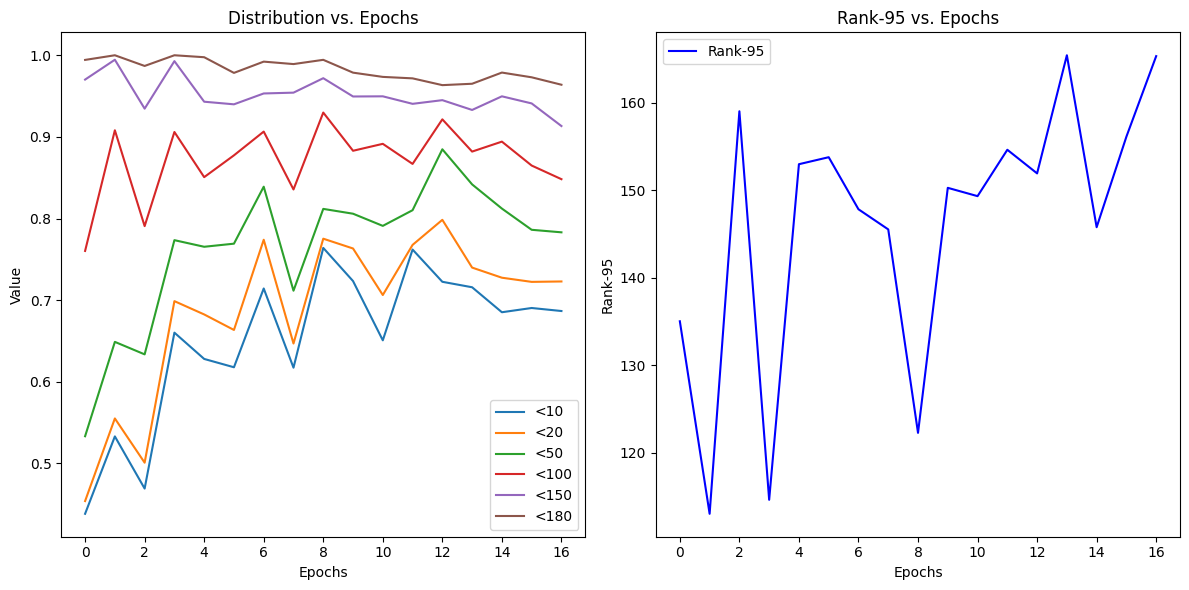

In [16]:
import matplotlib.pyplot as plt
import re

# Step 1: 读取 log.txt 并提取数据
with open('/wang_hp/zhy/SimGCD-main/dev_outputs/simgcd/log/Print-distribution-SimGCDloss_(12.09.2023_|_13.093)/log.txt', 'r') as file:
    lines = file.readlines()

lt_10, lt_20, lt_50, lt_100, lt_150, lt_180 = [], [], [], [], [], []
rank_95 = []

for line in lines:
    if "Old Distribution & Rank-95:" in line:
        lt_10.append(float(re.search('<10: ([0-9.]+)', line).group(1)))
        lt_20.append(float(re.search('<20: ([0-9.]+)', line).group(1)))
        lt_50.append(float(re.search('<50: ([0-9.]+)', line).group(1)))
        lt_100.append(float(re.search('<100: ([0-9.]+)', line).group(1)))
        lt_150.append(float(re.search('<150: ([0-9.]+)', line).group(1)))
        lt_180.append(float(re.search('<180: ([0-9.]+)', line).group(1)))
        rank_95.append(float(re.search('Rank-95: ([0-9.]+)', line).group(1)))

# Step 2: 使用 matplotlib 绘制图形
epochs = list(range(len(lt_10)))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, lt_10, label='<10')
plt.plot(epochs, lt_20, label='<20')
plt.plot(epochs, lt_50, label='<50')
plt.plot(epochs, lt_100, label='<100')
plt.plot(epochs, lt_150, label='<150')
plt.plot(epochs, lt_180, label='<180')
plt.title('Distribution vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, rank_95, color='blue', label='Rank-95')
plt.title('Rank-95 vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Rank-95')
plt.tight_layout()
plt.legend()
plt.show()


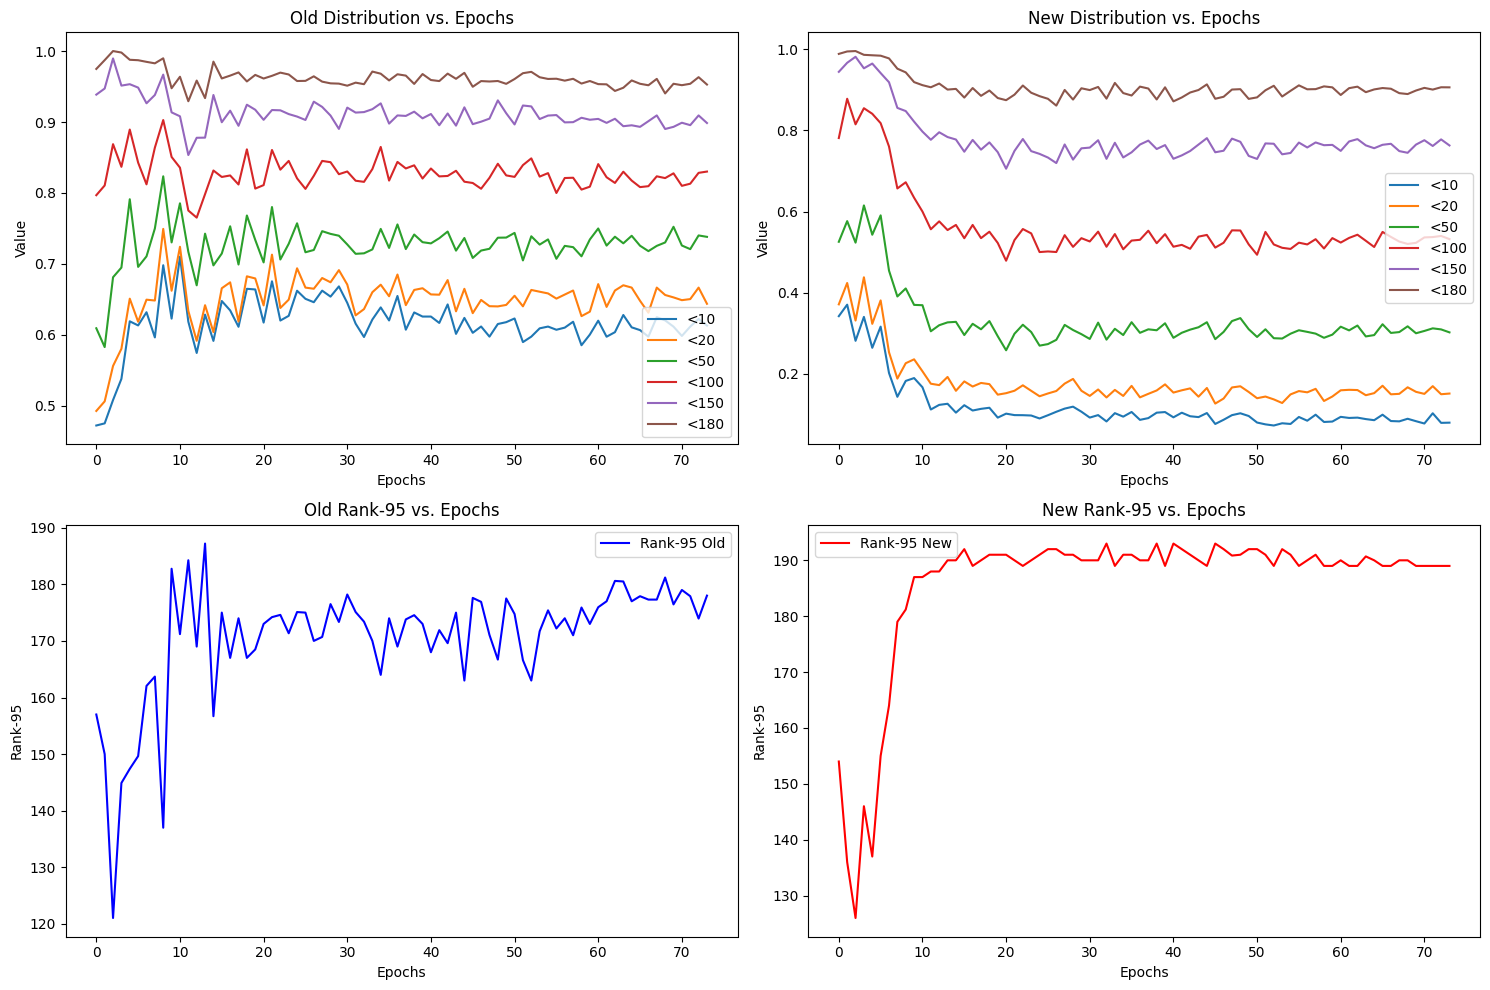

In [15]:
import matplotlib.pyplot as plt
import re

# Step 1: 读取 log.txt 并提取数据
with open('/wang_hp/zhy/SimGCD-main/dev_outputs/simgcd/log/simgcdloss-seed1-baseline_(14.09.2023_|_32.261)/log.txt', 'r') as file:
    lines = file.readlines()

lt_10_old, lt_20_old, lt_50_old, lt_100_old, lt_150_old, lt_180_old = [], [], [], [], [], []
lt_10_new, lt_20_new, lt_50_new, lt_100_new, lt_150_new, lt_180_new = [], [], [], [], [], []

rank_95_old, rank_95_new = [], []

for line in lines:
    if "Old Distribution & Rank-95:" in line:
        lt_10_old.append(float(re.search('<10: ([0-9.]+)', line).group(1)))
        lt_20_old.append(float(re.search('<20: ([0-9.]+)', line).group(1)))
        lt_50_old.append(float(re.search('<50: ([0-9.]+)', line).group(1)))
        lt_100_old.append(float(re.search('<100: ([0-9.]+)', line).group(1)))
        lt_150_old.append(float(re.search('<150: ([0-9.]+)', line).group(1)))
        lt_180_old.append(float(re.search('<180: ([0-9.]+)', line).group(1)))
        rank_95_old.append(float(re.search('Rank-95: ([0-9.]+)', line).group(1)))

    if "New Distribution & Rank-95:" in line:
        lt_10_new.append(float(re.search('<10: ([0-9.]+)', line).group(1)))
        lt_20_new.append(float(re.search('<20: ([0-9.]+)', line).group(1)))
        lt_50_new.append(float(re.search('<50: ([0-9.]+)', line).group(1)))
        lt_100_new.append(float(re.search('<100: ([0-9.]+)', line).group(1)))
        lt_150_new.append(float(re.search('<150: ([0-9.]+)', line).group(1)))
        lt_180_new.append(float(re.search('<180: ([0-9.]+)', line).group(1)))
        rank_95_new.append(float(re.search('Rank-95: ([0-9.]+)', line).group(1)))

# Step 2: 使用 matplotlib 绘制图形
epochs = list(range(len(lt_10_old)))

plt.figure(figsize=(15, 10))

# Old Distribution
plt.subplot(2, 2, 1)
plt.plot(epochs, lt_10_old, label='<10')
plt.plot(epochs, lt_20_old, label='<20')
plt.plot(epochs, lt_50_old, label='<50')
plt.plot(epochs, lt_100_old, label='<100')
plt.plot(epochs, lt_150_old, label='<150')
plt.plot(epochs, lt_180_old, label='<180')
plt.title('Old Distribution vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()

# New Distribution
plt.subplot(2, 2, 2)
plt.plot(epochs, lt_10_new, label='<10')
plt.plot(epochs, lt_20_new, label='<20')
plt.plot(epochs, lt_50_new, label='<50')
plt.plot(epochs, lt_100_new, label='<100')
plt.plot(epochs, lt_150_new, label='<150')
plt.plot(epochs, lt_180_new, label='<180')
plt.title('New Distribution vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()

# Old Rank-95
plt.subplot(2, 2, 3)
plt.plot(epochs, rank_95_old, color='blue', label='Rank-95 Old')
plt.title('Old Rank-95 vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Rank-95')
plt.legend()

# New Rank-95
plt.subplot(2, 2, 4)
plt.plot(epochs, rank_95_new, color='red', label='Rank-95 New')
plt.title('New Rank-95 vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Rank-95')
plt.tight_layout()
plt.legend()
plt.show()


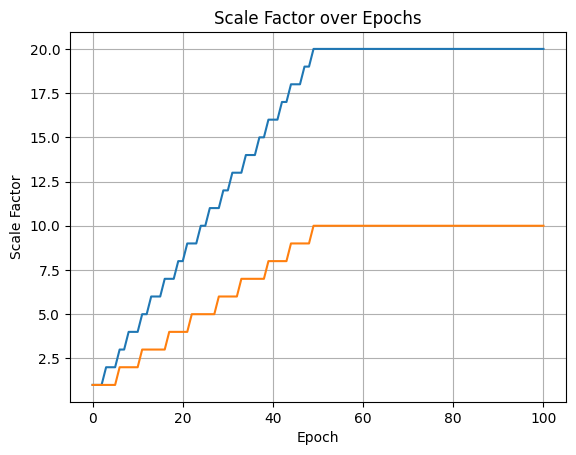

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math

# def scale_factor(epoch):
#     return (0.7)**epoch * 40 + 10
# # def scale_factor2(epoch):
# #     return (0.7)**epoch * 30 + 20
# # 定义一个范围的epoch
epochs = np.arange(0, 101)  # epoch范围是0-100
def scale_factor1(epoch):
    if epoch < 50:
        num_values_to_replace = 1 + (epoch * 19) // 49  # Linearly increase from 1 to 20 over 50 epochs
    else:
        num_values_to_replace = 20
    return num_values_to_replace
def scale_factor2(epoch):
    if epoch < 50:
        num_values_to_replace = 1 + (epoch * 9) // 49  # Linearly increase from 1 to 20 over 50 epochs
    else:
        num_values_to_replace = 10
    return num_values_to_replace
# 计算每个epoch对应的放大系数
scale_factors = [scale_factor1(epoch) for epoch in epochs]
scale_factors2 = [scale_factor2(epoch) for epoch in epochs]
# 绘制曲线
plt.plot(epochs, scale_factors)
plt.plot(epochs, scale_factors2)
plt.xlabel('Epoch')
plt.ylabel('Scale Factor')
plt.title('Scale Factor over Epochs')
plt.grid(True)
plt.show()

In [10]:
import math
def scale_factor1(epoch):
    return math.floor((0.7)**epoch * 49 + 1)
def scale_factor2(epoch):
    return math.floor((0.7)**epoch * 40 + 10)
def original_factor(epoch):
    if epoch < 50:
        num_values_to_replace = 1 + (epoch * 19) // 49  # Linearly increase from 1 to 20 over 50 epochs
    else:
        num_values_to_replace = 20
    return num_values_to_replace
print(scale_factor2(10))
print(original_factor(5))

11
2


In [21]:
# test on feature
# 输入：proj，label，mask，pseudo_label
# proj：形状是batchsize*featuresize，表示一个batch的特征，但是里面存在有标签特征和无标签特征
# label：形状是batchsize*1，是所有特征的标签，但是只有有标签的特征能用，通过mask来获取
# mask：形状是batchsize*1，布尔张量，label[mask]表示能使用的有标签数据的标签，proj[mask]表示能使用的有标签数据的特征
# pseudo_label：形状是batchsize*class_num，是分类头输出的logits，
# 已有模型model
我希望使用register_buffer()来保存多个字典，字典的key是0到class_num-1，对应class_num个类别，value是属于这个类别的特征，初始化时value是空的。
我希望有一个update_feature_bank方法用来更新字典：
输入proj，label，mask，pseudo_label
有标签的特征proj[mask]加入到对应key=label[mask]的字典中。
剩下的无标签特征，对它们的pseudo_label进行softmax，然后如果最大值大于0.9，就认为无标签特征属于这个类别，把特征加入到字典对应的类别中


SyntaxError: invalid character in identifier (3564485030.py, line 8)

In [ ]:
feature_bank = {i: [] for i in range(class_num)}

def update_feature_bank(self, proj, label, mask, pseudo_label):
    # 对于有标签的数据
    labeled_features = proj[mask]
    labeled_labels = label[mask]
    for feat, lbl in zip(labeled_features, labeled_labels):
        self.feature_bank[lbl.item()].append(feat)

    # 对于无标签的数据
    unlabeled_features = proj[~mask]
    probs = F.softmax(pseudo_label[~mask], dim=1)
    max_probs, predictions = probs.max(1)
    for feat, prob, pred in zip(unlabeled_features, max_probs, predictions):
        if prob > 0.9:
            self.feature_bank[pred.item()].append(feat)


In [ ]:
# 输入proj，pseudo-label，feature_bank，k
# proj：形状是batchsize*featuresize，表示一个batch的特征，但是里面存在有标签特征和无标签特征
# pseudo_label：形状是batchsize*class_num，是分类头输出的logits
# feature_bank = {i: [] for i in range(class_num)}
# k 整型
# 对于proj[i], 找到pseudo-label[i]中最小的k个值对应的k个类别。
# porj[i]要与feature_bank中这k个类别的特征远离
# 如何远离：用特征距离的倒数作为损失，例如norm(proj[i] - features[k])**2，result_for_i = np.sum([1/d for d in distances if d > 1e-8]) 
# 损失求平均，然后对porj每个特征都计算损失，然后平均
# feature_bank[i]可能为空，为空损失就为0

In [ ]:
import torch
import numpy as np

def compute_loss(proj, pseudo_label, feature_bank, k):
    batch_size, feature_size = proj.size()
    class_num = len(feature_bank)
    total_loss = 0

    # 对于每个proj[i]
    for i in range(batch_size):
        # 找到pseudo-label[i]中最小的k个值对应的类别
        _, class_indices = torch.topk(pseudo_label[i], k, largest=False)

        distances = []

        for idx in class_indices:
            features = feature_bank[idx.item()]
            
            # 如果feature_bank[i]不为空
            if features:
                for feature in features:
                    # 计算特征距离
                    distance = torch.norm(proj[i] - feature)**2
                    distances.append(distance.item())

        # 特征距离的倒数作为损失
        loss_for_i = np.sum([1/d for d in distances if d > 1e-8])
        total_loss += loss_for_i

    # 返回平均损失
    return total_loss / batch_size


In [ ]:
import torch

class YourModel(torch.nn.Module):
    def __init__(self, class_num, feature_size, max_features_per_class):
        super(YourModel, self).__init__()
        self.class_num = class_num
        self.feature_size = feature_size
        self.max_features_per_class = max_features_per_class
        
        # 使用buffer来保存特征和类别计数
        self.register_buffer('feature_bank', torch.zeros(class_num, max_features_per_class, feature_size))
        self.register_buffer('feature_counts', torch.zeros(class_num, dtype=torch.long))
        
    def compute_loss(self, proj, pseudo_label, k):
        _, class_indices = torch.topk(pseudo_label, k, largest=False, dim=1)
        batch_size = proj.size(0)
        losses = torch.zeros(batch_size).to(proj.device)

        for i in range(batch_size):
            distances = []
            for class_idx in class_indices[i]:
                class_count = self.feature_counts[class_idx].item()
                if class_count > 0:
                    class_features = self.feature_bank[class_idx, :class_count]
                    distance_matrix = (proj[i] - class_features).pow(2).sum(dim=1)
                    distances.append(distance_matrix)

            if distances:
                total_distances = torch.cat(distances)
                loss_for_i = (1.0 / (total_distances + 1e-8)).sum()
                losses[i] = loss_for_i

        return losses.mean()


In [35]:
import torch.nn.functional as F
class MyModel(torch.nn.Module):
    def __init__(self, class_num, feature_size, max_features_per_class):
        super(YourModel, self).__init__()
        self.class_num = class_num
        self.feature_size = feature_size
        self.max_features_per_class = max_features_per_class
        
        # 使用buffer来保存特征和类别计数
        self.register_buffer('feature_bank', torch.zeros(class_num, max_features_per_class, feature_size))
        self.register_buffer('feature_counts', torch.zeros(class_num, dtype=torch.long))

    def reset_feature_bank(self):
        """重置特征库在每个epoch开始时调用"""
        self.feature_bank.zero_()
        self.feature_counts.zero_()

    def update_feature_bank(self, proj, label, mask, pseudo_label):
        # 对于有标签的数据
        labeled_features = proj[mask]
        labeled_labels = label[mask]
        for feat, lbl in zip(labeled_features, labeled_labels):
            if self.feature_counts[lbl] < self.max_features_per_class:
                self.feature_bank[lbl, self.feature_counts[lbl]] = feat
                self.feature_counts[lbl] += 1

        # 对于无标签的数据
        unlabeled_features = proj[~mask]
        probs = F.softmax(pseudo_label[~mask], dim=1)
        max_probs, predictions = probs.max(1)
        
        # 获取后100类
        # valid_classes = list(range(self.class_num - 100, self.class_num))
        
        for feat, prob, pred in zip(unlabeled_features, max_probs, predictions):
            if prob > 0.95: #and pred.item() in valid_classes:
                if self.feature_counts[pred] < self.max_features_per_class:
                    self.feature_bank[pred, self.feature_counts[pred]] = feat
                    self.feature_counts[pred] += 1
                    
    def compute_loss(self, proj, pseudo_label, k):
        _, class_indices = torch.topk(pseudo_label, k, largest=False, dim=1)
        batch_size = proj.size(0)
        losses = torch.zeros(batch_size).to(proj.device)

        for i in range(batch_size):
            distances = []
            for class_idx in class_indices[i]:
                class_count = self.feature_counts[class_idx].item()
                if class_count > 0:
                    class_features = self.feature_bank[class_idx, :class_count]
                    distance_matrix = torch.sqrt((proj[i] - class_features).pow(2)).sum(dim=1)
                    distances.append(distance_matrix)

            if distances:
                total_distances = torch.cat(distances)
                loss_for_i = (1.0 / (total_distances + 1e-8)).sum()
                losses[i] = loss_for_i

        return losses.mean()

In [1]:
# 构造简单的测试用例
import torch

# 定义数据参数
batch_size = 10
feature_dim = 2
class_num = 3
labeled_count = 4

# 生成数据
proj = torch.randn(batch_size, feature_dim) # 10个随机特征，每个特征的维度是2

# 为前4个样本分配标签
label = torch.LongTensor([0, 1, 2, 0] + [0]*(batch_size - labeled_count)) # 前4个有标签，其余为0

# 创建mask
mask = torch.BoolTensor([True]*labeled_count + [False]*(batch_size - labeled_count))

# 生成伪标签
# 对于伪标签，我们只为未标记的样本生成，这里我们简单地给每个样本一个随机的logit
pseudo_logits = torch.randn(batch_size, class_num)
pseudo_label = torch.softmax(pseudo_logits, dim=1)

print("proj:")
print(proj)
print("\nlabel:")
print(label)
print("\nmask:")
print(mask)
print("\npseudo_label:")
print(pseudo_label)

/opt/conda/envs/gcd/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


proj:
tensor([[-1.0785, -0.4975],
        [-1.0829, -2.0877],
        [ 0.0449, -0.3596],
        [ 0.2579,  0.7316],
        [-1.1912, -0.1109],
        [ 0.9485,  0.7814],
        [-0.9142, -0.5909],
        [ 0.8568, -0.1523],
        [ 0.7530, -0.3212],
        [ 0.7333,  1.7810]])

label:
tensor([0, 1, 2, 0, 0, 0, 0, 0, 0, 0])

mask:
tensor([ True,  True,  True,  True, False, False, False, False, False, False])

pseudo_label:
tensor([[0.6726, 0.1032, 0.2242],
        [0.6249, 0.2034, 0.1717],
        [0.2556, 0.4273, 0.3172],
        [0.2840, 0.3953, 0.3208],
        [0.2589, 0.0708, 0.6704],
        [0.4141, 0.2722, 0.3137],
        [0.5027, 0.1793, 0.3181],
        [0.3924, 0.5453, 0.0622],
        [0.2500, 0.0708, 0.6791],
        [0.3285, 0.5568, 0.1147]])


In [47]:
label=torch.tensor([0, 1, 2, 1, 0, 0, 0, 0, 0, 0])

In [48]:
model = YourModel(class_num, feature_dim, 3)

In [49]:
model.update_feature_bank(proj, label, mask, pseudo_label/0.1)

In [50]:
model.feature_bank

tensor([[[-1.0785, -0.4975],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000]],

        [[-1.0829, -2.0877],
         [ 0.2579,  0.7316],
         [ 0.0000,  0.0000]],

        [[ 0.0449, -0.3596],
         [-1.1912, -0.1109],
         [ 0.7530, -0.3212]]])

In [51]:
# import numpy as np
# def mysoftmax(x):
#     e_x = np.exp(x - np.max(x))
#     return e_x / e_x.sum(axis=0)
# mysoftmax(np.array([0.2589, 0.0708, 0.6704])/0.1)
model.feature_counts

tensor([1, 2, 3])

In [52]:
model.compute_loss(proj,pseudo_label,1)

tensor(1.3915)

In [42]:
_, class_indices = torch.topk(pseudo_label, 1, largest=False, dim=1)
class_indices

tensor([[1],
        [2],
        [0],
        [0],
        [1],
        [1],
        [1],
        [2],
        [1],
        [2]])

In [45]:
class_count = model.feature_counts[0].item()
class_idx = class_indices[0]
distance_matrix = torch.sqrt((proj[1] - model.feature_bank[class_idx, :class_count]).pow(2)).sum(dim=1)
distance_matrix

tensor([[1.0829, 2.0877]])